In [1]:
import os
import pandas as pd
import numpy as np
import re
import jieba
from collections import defaultdict
from gensim import corpora
from jieba import analyse

In [2]:
os.chdir(r"D:\gechengcheng3\Desktop\hotpot")
raw_data = pd.read_csv(r"gcc_hotpot_search_0721_20200721185640.csv", sep='\t')
pd.set_option("display.max_row", 50)

In [4]:
raw_data.head(30)

,keyword,dt_month,search_time
0,NaN,2019-07,1779
1,NaN,2019-08,1868
2,NaN,2019-09,2509
3,NaN,2019-10,1886
4,NaN,2019-11,2816
5,NaN,2019-12,2392
6,NaN,2020-01,3293
7,NaN,2020-02,1762
8,NaN,2020-03,2304
9,NaN,2020-04,3892


In [55]:
# 统计每一个月的非空占比
data_df_nan_1 = raw_data.groupby(["dt_month"])["search_time"].agg([np.sum])
# data_df_nan.concat(raw_data.loc[raw_data])
data_df_nan_2 = raw_data.loc[raw_data["keyword"].isnull(),:][["dt_month","search_time"]]

In [57]:
data_df_nan_1.rename(columns={'sum':'search_time'}, inplace=True)

In [74]:
data_df_nan_3 = pd.DataFrame(data_df_nan_2["search_time"].values,index=data_df_nan_2["dt_month"],columns=["search_time_null"])

In [75]:
data_null_df = pd.concat([data_df_nan_1,data_df_nan_3["search_time_null"]],axis=1)
data_null_df["null占比"] = data_null_df["search_time_null"]/data_null_df["search_time"]

In [76]:
data_null_df['非null占比'] = 1-data_null_df["search_time_null"]/data_null_df["search_time"]
data_null_df

,search_time,search_time_null,null占比,非null占比
dt_month,,,,
2019-07,2863000,1779,0.000621,0.999379
2019-08,2378650,1868,0.000785,0.999215
2019-09,2075974,2509,0.001209,0.998791
2019-10,2110658,1886,0.000894,0.999106
2019-11,2474518,2816,0.001138,0.998862
2019-12,2071512,2392,0.001155,0.998845
2020-01,3245432,3293,0.001015,0.998985
2020-02,11573648,1762,0.000152,0.999848
2020-03,4997560,2304,0.000461,0.999539


In [89]:
raw_data = raw_data.dropna(axis=0).reset_index(range(len(raw_data)),drop=True)

In [90]:
raw_data

,keyword,dt_month,search_time
0,海鲜自煮火锅,2020-03,2
1,自热,2019-11,1
2,自热火锅。,2019-09,2
3,...,2020-06,1
4,【整箱】 德庄 重庆特产 即食方便 自煮自热 懒人小火锅...,2019-10,1
5,【整箱】螺霸王 自热螺蛳粉 （原味) 广西柳州特产 自煮自...,2019-07,1
6,【整箱】螺霸王 自热螺蛳粉 （原味) 广西柳州特产 自煮自...,2019-09,1
7,【整箱装】食人谷 网红懒人自热火锅 老火锅重庆麻辣自热小...,2019-09,1
8,三只松鼠素食小火锅麻辣味350g/盒 自热小火锅懒人自助方便速食,2019-11,2
9,三只松鼠素食小火锅麻辣味350g/盒 自热小火锅懒人自助方便速食,2019-12,1


In [121]:
corpus_clean = []
fil = re.compile(r'[^0-9.\u4e00-\u9fa5]+')
for raw in raw_data.loc[:, "keyword"]:
    raw = fil.sub('', str(raw))
    raw = raw.strip()
    corpus_clean.append(raw)

In [122]:
corpus_clean

['海鲜自煮火锅',
 '自热',
 '自热火锅',
 '云南特产散装米线',
 '整箱德庄重庆特产即食方便自煮自热懒人小火锅285',
 '整箱螺霸王自热螺蛳粉原味广西柳州特产自煮自热火锅懒人即食方便速食268',
 '整箱螺霸王自热螺蛳粉原味广西柳州特产自煮自热火锅懒人即食方便速食2685盒',
 '整箱装食人谷网红懒人自热火锅老火锅重庆麻辣自热小火锅39012盒',
 '三只松鼠素食小火锅麻辣味350盒自热小火锅懒人自助方便速食',
 '三只松鼠素食小火锅麻辣味350盒自热小火锅懒人自助方便速食',
 '小肥羊自热小火锅麻辣素菜自煮懒人小暖锅440',
 '小龍坎小龙坎牛油素菜方便火锅365',
 '小龍坎小龙坎经典牛油方便火锅3.0版418',
 '自嗨锅麻辣肥牛自热火锅170',
 '食人谷麻辣自热火锅390自热式懒人自煮方便火锅海底捞麻辣烫川粉',
 '食人谷麻辣自热老火锅390',
 '包邮海底捞自热小火锅懒人自煮火锅方便火锅清油麻辣嫩牛435',
 '单品包邮财成点饭吃咖喱鸡肉饭320盒宏绿自热米饭生产日期19年08月',
 '整箱螺霸王自热螺蛳粉原味广西柳州特产自煮自热火锅懒人即食方便速食268',
 '高毛利高金食品碗装粉蒸肉350碗6碗装成品菜肴加热即食',
 '嗨吃家自热小火锅240盒方便速食正宗重庆麻辣牛油底料网红懒人自煮麻辣烫',
 '小龍坎小龙坎方便火锅粉295',
 '小龍坎小龙坎红油钵钵鸡333',
 '海底捞麻辣嫩牛自煮火锅自热懒人火锅435新老包装',
 '海底捞麻辣嫩牛自煮火锅自热懒人火锅435新老包装',
 '海底捞麻辣嫩牛自煮火锅自热懒人火锅435新老包装',
 '筷时尚番茄味自热火锅290',
 '自嗨锅牛肉重庆小面冲泡103',
 '良品铺子网红自热螺蛳粉柳州正宗特产方便速食酸辣粉米线桶装懒人火锅256',
 '莫小仙麻辣味自热火锅网红方便火锅350',
 '食人谷网红懒人自热火锅老火锅番茄牛腩自热小火锅370盒',
 '食人谷网红懒人自热火锅老火锅麻辣嫩牛自热小火锅400盒',
 '海底捞自煮火锅麻辣懒人小火锅方便速食自热米饭即食自助5盒装麻辣烫麻辣嫩牛番茄牛腩脆爽牛肚番茄小酥肉香辣素食',
 '自热火锅',
 '16海底捞京东自营自热火锅方便速食清油麻辣嫩牛自热食品火锅套餐435',
 '嗨一嗨菜',
 '小火锅'

In [127]:
def fenci(data):    
    return " ".join(jieba.cut(data)).split()
jieba.load_userdict("userdict.txt")

In [172]:
list_clean_corpus = []
for i,j in zip(corpus_clean,raw_data["search_time"].values):
    temp = fenci(i)*j
    list_clean_corpus.append(temp)
# 30s

In [174]:
list_clean_corpus[2]

['自热', '火锅', '自热', '火锅']

In [175]:
f=open('stop_words.txt', "r", encoding='UTF-8')
stop_words_string = f.readlines()
f.close()
stop_word = [x[:-1] for x in stop_words_string] # 去除"\n"
stop_word.append("京东")
stop_word.append("自营")
stop_word.append("火锅")
stop_word.append("小火锅")

In [176]:
L_corpus = []
for text in list_clean_corpus:
    l_temp = []
    for word in text:
        if word not in stop_word:
            l_temp.append(word)
    L_corpus.append(l_temp)

In [179]:
L_corpus[:5]

[['海鲜', '自煮', '海鲜', '自煮'],
 ['自热'],
 ['自热', '自热'],
 ['云南', '特产', '散装', '米线'],
 ['整箱', '德庄', '重庆', '特产', '即食', '方便', '自煮', '自热', '懒人', '285']]

In [166]:
L_corpus_filter_one = [[x for x in text if len(x)>1] for text in L_corpus]

In [178]:
# 统计词频
frequency = defaultdict(int)
for text in L_corpus_filter_one:
    for token in text:
        frequency[token] += 1
# print(len(frequency))
frequency_sort = sorted(frequency.items(), key=lambda x: x[1], reverse=True)
frequency_sort = pd.DataFrame(frequency_sort, columns=["词语", "词频"])
print("打印词频如下表:","\n")
frequency_sort[:10]

打印词频如下表: 



,词语,词频
0,自热,119172
1,海底捞,52364
2,自嗨锅,33760
3,速食,25318
4,方便,25037
5,自煮,24781
6,麻辣,22618
7,自助,21962
8,懒人,21121
9,牛肉,16242


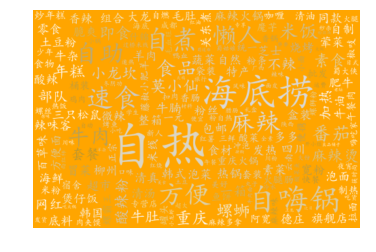

In [169]:
# 绘制词云图可视化搜索关键词
%matplotlib inline
from wordcloud import WordCloud  # 词云展示模块
from wordcloud import ImageColorGenerator
import PIL.Image as image  # 图像处理模块
import matplotlib.pyplot as plt  # 图像展示模块
import matplotlib.font_manager as fm  # 中文处理模块
sentence = []
for sent in L_corpus_filter_one:
    text = " ".join(sent)
    sentence.append(text)
text = " ".join(sentence)
mask = np.array(image.open('2.jpg'))  # 图片背景参考形状
wc = WordCloud(
    background_color="orange",  # 背景颜色
    max_words=200,  # 最多显示的词数
    mask=mask,  # 设置图片的背景
    collocations=False,
    max_font_size=80,  # 最大的字符
    random_state=10,  # 设置有多少种随机生成状态，即有多少种配色方案
    font_path=r'C:/Windows/Fonts/simkai.ttf'  # 中文处理，用系统自带的字体
).generate(text)  # generate 只能处理str文本不能处理list文本
# 对词云图各项参数进行调整，使词云图更美观
my_font = fm.FontProperties(fname=r'C:/Windows/Fonts/simkai.ttf')  # 词云字体设置
image_colors = ImageColorGenerator(mask)  # 基于彩色图像的颜色生成器 提取背景图片颜色
wc.recolor(color_func=image_colors)  # 将词云颜色设置为背景图的颜色
plt.axis("off")  # 为云图去掉坐标轴
plt.imshow(wc, interpolation="bilinear")  # 开始画图
wc.to_file("search_keywords.png")  # 输出一个png文件保存云图

In [177]:
# 以下思路待修缮

In [ ]:
# try1:搜索关键字，词聚类，不考虑不同类用户特性，一把抓
# 训练词向量
# 使用 gensim 中的 word2vec训练词向量
model = Word2Vec(fenci_list, size=200, workers=5, sg=1)  # 生成词向量为200维，考虑上下5个单词共10个单词，采用sg=1的方法也就是skip-gram
model.save("word2vec.model")
model = Word2Vec.load("word2vec.model")
model.train(fenci_list, total_examples=1, epochs=1)
model.wv.most_similar("份量")
model.wv.most_similar("味道")
model.wv.most_similar(u"海底捞")  # 默认10个,加u不加u没有区别
model.wv.most_similar("自嗨锅", topn=5)  # 找出最相似的前20个词

# 建立词向量词典
w2c = {}
w2c_list = []
for word in list(frequency.keys()):  # dict_keys
    try:
        w2c[word] = model.wv[word]
        w2c_list.append(model.wv[word])
    except:
        pass
# test
vec1 = model.wv["自嗨锅"]
vec2 = model.wv["羊肉"]
vec3 = model.wv["重庆"]  # 此处必要要加wv,否则会发出警告

# 根据词向量进行词聚类——k-means
data = np.array(w2c_list)
k_means = KMeans(n_clusters=5, random_state=10).fit(data)

# 输出聚类中心，解决不可迭代问题
cluster_centers_5 = k_means.cluster_centers_  # array
clus_set_shape_modify = []
for cc in cluster_centers_5:
    #print(cc.shape)
    cc = cc[np.newaxis, :]
    #print(cc.shape)
    clus_set_shape_modify.append(cc)

# 解决完毕，开始迭代找五个类别的相似词
clus_set_all = [model.wv.most_similar(clus_set_shape_modify[i], topn=30) for i in range(5)]

# 绘制词云图可视化搜索关键词
from wordcloud import WordCloud  # 词云展示模块
from wordcloud import ImageColorGenerator
import PIL.Image as image  # 图像处理模块
import matplotlib.pyplot as plt  # 图像展示模块
import matplotlib.font_manager as fm  # 中文处理模块
sentence = []
for sent in fenci_list:
    text = " ".join(sent)
    sentence.append(text)
text = " ".join(sentence)
mask = np.array(image.open('1.jpg'))  # 图片背景参考形状
wc = WordCloud(
    background_color="white",  # 背景颜色
    max_words=100,  # 最多显示的词数
    mask=mask,  # 设置图片的背景
    max_font_size=80,  # 最大的字符
    random_state=10,  # 设置有多少种随机生成状态，即有多少种配色方案
    font_path=r'C:/Windows/Fonts/simkai.ttf'  # 中文处理，用系统自带的字体
).generate(text)  # generate 只能处理str文本不能处理list文本
# 对词云图各项参数进行调整，使词云图更美观
my_font = fm.FontProperties(fname=r'C:/Windows/Fonts/simkai.ttf')  # 词云字体设置
image_colors = ImageColorGenerator(mask)  # 基于彩色图像的颜色生成器 提取背景图片颜色
wc.recolor(color_func=image_colors)  # 将词云颜色设置为背景图的颜色
plt.axis("off")  # 为云图去掉坐标轴
plt.imshow(wc, interpolation="bilinear")  # 开始画图
wc.to_file("search_keywords.png")  # 输出一个png文件保存云图